In [1]:
from copy import copy

import numpy as np
import time

from lcode2dPy.plasma.initialization import init_plasma
from lcode2dPy.plasma.solver import CylindricalPlasmaSolver
from lcode2dPy.beam.beam_slice import BeamSlice
from lcode2dPy.beam.beam_io import MemoryBeamSource, MemoryBeamDrain
from lcode2dPy.push_solver import PusherAndSolver
from lcode2dPy.beam.beam_generator import *

from lcode2dPy.config.default_config import default_config

In [2]:
start_time = time.time()
config = copy(default_config)
config.set('geometry', 'circ')
config.set('window-width', 16)
config.set('window-length', 30)
config.set('plasma-particles-per-cell', 10)
config.set('r-step', 0.01)
config.set('xi-step', 0.01)
config.set('time-step', 100)
config.set('indication-line-period', 1)
config.set('corrector-steps', 1)

solver = CylindricalPlasmaSolver(config)

R_MAX = config.getfloat('window-width')
D_R = config.getfloat('r-step')
J_MAX = int(R_MAX / D_R)
D_XIP = config.getfloat('xi-step')
xi_max = config.getfloat('window-length')
r_mesh = np.arange(J_MAX + 1) * D_R

# Plasma
xi = 0
fields, particles = init_plasma(config)

# Beam
gamma = 426
angspread = 1e-5
m_proton = 958/0.51
Ipeak_kA = 40/1000

xi_distr = Gauss(vmin=-10, vmax=0)
r_distr = rGauss(vmin=0, vmax=16)
angle_distr = Gauss(sigma=angspread, vmin=None, vmax=None)
pz_distr = Gauss(gamma*m_proton, gamma*m_proton*1e-4, vmin=None, vmax=None)

beam = make_beam(config=config, xi_distr=xi_distr, r_distr=r_distr, ang_distr=angle_distr, pz_distr=pz_distr,
                     Ipeak_kA=Ipeak_kA, q_m=1/m_proton)
particle_dtype = np.dtype([('xi', 'f8'), ('r', 'f8'), ('p_z', 'f8'), ('p_r', 'f8'), ('M', 'f8'), ('q_m', 'f8'),
                           ('q_norm', 'f8'), ('id', 'i8')])
beam = np.array(list(map(tuple, beam.to_numpy())), dtype=particle_dtype)

_beam = BeamSlice(beam.size, beam)
beam_source = MemoryBeamSource(_beam) #TODO mpi_beam_source
beam_drain = MemoryBeamDrain()

Number of particles: 50133
Number of particles in the middle layer: 200


In [3]:
PAS = PusherAndSolver(config)

In [4]:
particles, fields = PAS.step_dt(particles, fields, beam_source, beam_drain, 0)

xi=-0.000000 Ez=0.000000e+00 N=1
xi=-1.000000 Ez=-3.044674e-03 N=1
xi=-2.000000 Ez=-1.284500e-03 N=1
xi=-3.000000 Ez=2.833309e-03 N=1
xi=-4.000000 Ez=4.529274e-03 N=1
xi=-5.000000 Ez=2.079948e-03 N=1
xi=-6.000000 Ez=-2.257207e-03 N=1
xi=-7.000000 Ez=-4.545133e-03 N=1
xi=-8.000000 Ez=-2.657261e-03 N=1
xi=-9.000000 Ez=1.702368e-03 N=1
xi=-10.000000 Ez=4.475724e-03 N=1
xi=-11.000000 Ez=3.123288e-03 N=1
xi=-12.000000 Ez=-1.070693e-03 N=1
xi=-13.000000 Ez=-4.294215e-03 N=1
xi=-14.000000 Ez=-3.588242e-03 N=1
xi=-15.000000 Ez=4.462370e-04 N=1
xi=-16.000000 Ez=4.064373e-03 N=1
xi=-17.000000 Ez=3.921402e-03 N=1
xi=-18.000000 Ez=1.994454e-04 N=1
xi=-19.000000 Ez=-3.703430e-03 N=1
xi=-20.000000 Ez=-4.229746e-03 N=1
xi=-21.000000 Ez=-8.462006e-04 N=1
xi=-22.000000 Ez=3.326241e-03 N=1
xi=-23.000000 Ez=4.410299e-03 N=1
xi=-24.000000 Ez=1.453995e-03 N=1
xi=-25.000000 Ez=-2.821030e-03 N=1
xi=-26.000000 Ez=-4.531700e-03 N=1
xi=-27.000000 Ez=-2.069869e-03 N=1
xi=-28.000000 Ez=2.319436e-03 N=1
xi=-29.000

In [5]:
new_beam=beam_drain.beam_slice()

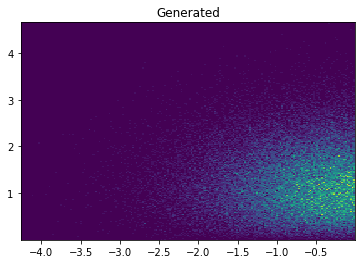

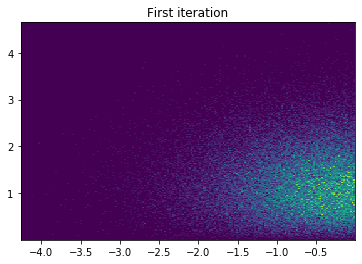

In [7]:
import matplotlib.pyplot as plt
plt.hist2d(beam[:-1]['xi'],beam[:-1]['r'],200)
plt.title('Generated')
plt.show()
plt.hist2d(new_beam['xi'],new_beam['r'],200)
plt.title('First iteration')
plt.show()

In [10]:
beam

array([(-2.49992847e-05, 0.84314259, 800135.83420655,   4.85041371,   4.07986589, 5.32359081e-04, 2.34833915e-05,     0),
       (-4.99985693e-05, 1.77689592, 800114.52068725, -11.97283817,  19.08693634, 5.32359081e-04, 2.34833915e-05,     1),
       (-7.49978541e-05, 1.2743257 , 800409.98726181,  15.10705539, -28.16509526, 5.32359081e-04, 2.34833915e-05,     2),
       ...,
       (-4.10809798e+00, 0.97078229, 800237.88319419,  -1.34948635,   2.63241447, 5.32359081e-04, 2.34833915e-05, 50131),
       (-4.26548834e+00, 1.80649106, 800327.74181609,  -7.51620632,  -8.55037773, 5.32359081e-04, 2.34833915e-05, 50132),
       (-1.00000000e+05, 0.        ,      0.        ,   0.        ,   0.        , 1.00000000e+00, 0.00000000e+00,     0)],
      dtype=[('xi', '<f8'), ('r', '<f8'), ('p_z', '<f8'), ('p_r', '<f8'), ('M', '<f8'), ('q_m', '<f8'), ('q_norm', '<f8'), ('id', '<i8')])

In [11]:
new_beam.sort(order=['id'])

In [12]:
new_beam

array([(-3.00572633e-04, 0.843749  , 800135.83169435,   4.85387324,   4.0798659 , 0.00053236, 2.34833915e-05,     0),
       (-3.25603140e-04, 1.77540004, 800114.51931435, -11.9647214 ,  19.08693635, 0.00053236, 2.34833915e-05,     1),
       (-3.50434731e-04, 1.2762161 , 800409.98525234,  15.15483098, -28.16509527, 0.00053236, 2.34833915e-05,     2),
       ...,
       (-4.01371775e+00, 2.07371169, 800343.39009238,  -7.2656822 ,  11.59297107, 0.00053236, 2.34833915e-05, 50130),
       (-4.10837348e+00, 0.97061624, 800238.22198097,  -1.30813837,   2.63240763, 0.00053236, 2.34833915e-05, 50131),
       (-4.26576378e+00, 1.80555586, 800327.91878058,  -7.45324637,  -8.55035957, 0.00053236, 2.34833915e-05, 50132)],
      dtype=[('xi', '<f8'), ('r', '<f8'), ('p_z', '<f8'), ('p_r', '<f8'), ('M', '<f8'), ('q_m', '<f8'), ('q_norm', '<f8'), ('id', '<i8')])

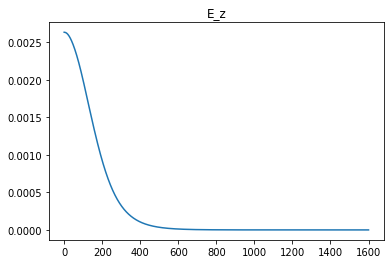

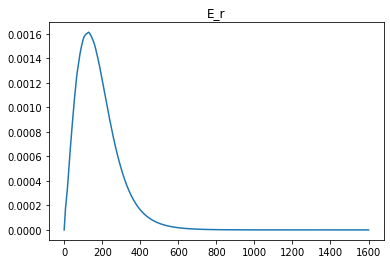

In [13]:
plt.plot(np.array(fields.E_z))
plt.title('E_z')
plt.show()
plt.plot(np.array(fields.E_r))
plt.title('E_r')
plt.show()